## I. Importing all the necessary libraries

In [ ]:
#!pip install opencv-python

In [ ]:
!python.exe -m pip install --upgrade pip

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import datasets, layers, models, callbacks
import matplotlib.pyplot as plt

import tensorflow as tf

## II. Reading the datasets

In [ ]:
train_dir = "your_source_directory"
test_dir = "your_source_directory"
train_df = pd.read_csv("your_source_directory")
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


## III. Displaying the images

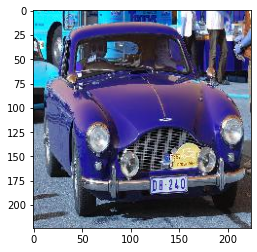

In [ ]:
im = cv2.imread("your_source_directory")
plt.imshow(im)

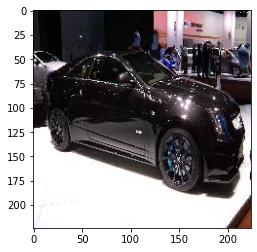

In [ ]:
im2 = cv2.imread("your_source_directory")
plt.imshow(im2)

#### Setting all datatypes to string

In [ ]:
train_df.emergency_or_not=train_df.emergency_or_not.astype(str)

## IV. Configuring the Image Data Generator

### In this part of the code, we do the following :-

- #### Configure the Image Data Generator and specify the transformations
- #### Have a train-test split ratio of 70-30.
- #### Get the dimensions of the training and validation generators.
- #### Finding the total number of samples for both training and validation generators


#### *Configuring image data generator and specifying the transformations*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True)
batch_size = 32

#### *Setting up the generator for training and validation data*

In [ ]:
traingen = datagen.flow_from_dataframe(dataframe = train_df[:1150],directory = train_dir,x_col ='image_names',
                                            y_col = 'emergency_or_not',class_mode = 'binary',batch_size = batch_size,
                                            target_size = (32,32))


valgen = datagen.flow_from_dataframe(dataframe = train_df[1151:],directory = train_dir,x_col = 'image_names',
                                                y_col ='emergency_or_not',class_mode ='binary',batch_size = 50,
                                                target_size = (32,32))

Found 1150 validated image filenames belonging to 2 classes.
Found 495 validated image filenames belonging to 2 classes.


#### *Finding the dimensions of training and validation generators*

In [ ]:
trainsample = next(traingen)
print("Dimensions of training sample",trainsample[0].shape)
valsample = next(valgen)
print("Dimensions of validation sample",valsample[0].shape)

Dimensions of training sample (32, 32, 32, 3)
Dimensions of validation sample (50, 32, 32, 3)


#### *Finding the number of samples in each generator*

In [ ]:
num_train_samples = traingen.samples
num_val_samples = valgen.samples

print("Number of training samples", num_train_samples)
print("Number of validation samples", num_val_samples)

Number of training samples 1150
Number of validation samples 495


## V.   Making the CNN


  ### (1) With Data Augmentation

#### *(a) Building the network*

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), padding="same"))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

op = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits = False)
model.compile(optimizer = op, loss = loss, metrics = ['accuracy'])

history = model.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 6s 259ms/step - loss: 0.6725 - accuracy: 0.5899 - val_loss: 0.6163 - val_accuracy: 0.6970
Epoch 2/50
23/23 [==============================] - 3s 113ms/step - loss: 0.5792 - accuracy: 0.6929 - val_loss: 0.5436 - val_accuracy: 0.7475
Epoch 3/50
23/23 [==============================] - 2s 80ms/step - loss: 0.5440 - accuracy: 0.7125 - val_loss: 0.5358 - val_accuracy: 0.7475
Epoch 4/50
23/23 [==============================] - 2s 68ms/step - loss: 0.5174 - accuracy: 0.7432 - val_loss: 0.5494 - val_accuracy: 0.7354
Epoch 5/50
23/23 [==============================] - 2s 69ms/step - loss: 0.4957 - accuracy: 0.7698 - val_loss: 0.5065 - val_accuracy: 0.7515
Epoch 6/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4575 - accuracy: 0.7894 - val_loss: 0.5318 - val_accuracy: 0.7394
Epoch 7/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4397 - accuracy: 0.7902 - val_loss: 0.4786 - val_accuracy: 0.7778
Epoch 8/50


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### *(b) Graphing the losses and accuracy*

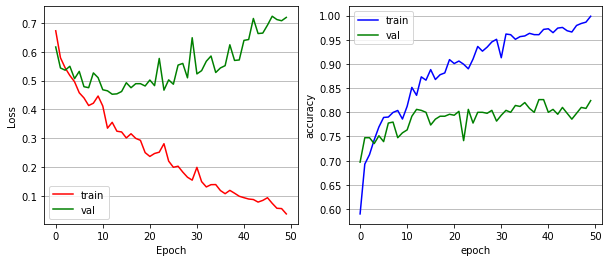

In [ ]:
figure = plt.figure(figsize = (10,4))
ax = plt.subplot(121)

ax.plot(history.history['loss'], 'r', label = 'train')
ax.plot(history.history['val_loss'],'g',label = 'val')

plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")

ax2 = plt.subplot(122)
ax2.plot(history.history['accuracy'], 'b', label="train")
ax2.plot(history.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')
plt.savefig("Emergency dataset with data augmentation")

### (2) Early Stopping

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_es.h5', monitor = 'val_loss',verbose=0, save_best_only=True)

#### *(a) Building the network*

In [ ]:
model2 = Sequential()
model2.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), padding="same"))
model2.add(tf.keras.layers.MaxPooling2D(2,2))
model2.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(10))
model2.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

callbacks = [early_stopping_callback, model_checkpoint_callback]

model2.compile(optimizer = op,
              loss = loss,
              metrics=['accuracy'])

history2 = model2.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50, callbacks = callbacks)

model2.summary()

Epoch 1/50
23/23 [==============================] - 2s 84ms/step - loss: 0.6690 - accuracy: 0.5666 - val_loss: 0.6645 - val_accuracy: 0.6828
Epoch 2/50
23/23 [==============================] - 2s 67ms/step - loss: 0.5872 - accuracy: 0.6957 - val_loss: 0.5439 - val_accuracy: 0.7333
Epoch 3/50
23/23 [==============================] - 2s 67ms/step - loss: 0.5467 - accuracy: 0.7221 - val_loss: 0.4921 - val_accuracy: 0.7596
Epoch 4/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4913 - accuracy: 0.7405 - val_loss: 0.4863 - val_accuracy: 0.7657
Epoch 5/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4841 - accuracy: 0.7684 - val_loss: 0.4651 - val_accuracy: 0.7899
Epoch 6/50
23/23 [==============================] - 1s 61ms/step - loss: 0.4614 - accuracy: 0.7861 - val_loss: 0.5455 - val_accuracy: 0.7475
Epoch 7/50
23/23 [==============================] - 1s 63ms/step - loss: 0.4319 - accuracy: 0.7976 - val_loss: 0.4618 - val_accuracy: 0.7899
Epoch 8/50
23

In [ ]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### *(b) Graphing*

Text(0.5, 1.0, 'CNN + Data Augmentation + Early Stopping - Epoch VS Loss')

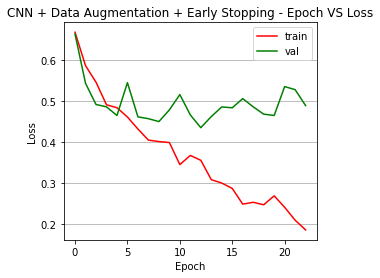

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history2.history['loss'], 'r', label = 'train')
ax.plot(history2.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + Early Stopping - Epoch VS Loss")

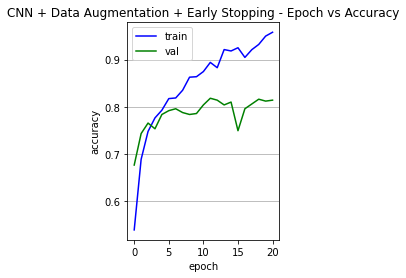

In [ ]:
ax2 = plt.subplot(122)
ax2.plot(history2.history['accuracy'], 'b', label="train")
ax2.plot(history2.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')

plt.title("CNN + Data Augmentation + Early Stopping - Epoch vs Accuracy")
plt.savefig("Emergency dataset with data augmentation + early stopping")

### (3) Dropouts

#### Dropout with 0.2

#### *(a) Building the network*

In [ ]:
model3 = Sequential()

model3.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), padding="same")),
model3.add(tf.keras.layers.MaxPooling2D(2,2)),
model3.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")),
model3.add(tf.keras.layers.Flatten()),
model3.add(tf.keras.layers.Dropout(0.2)),
model3.add(tf.keras.layers.Dense(10)),
model3.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))



model3.compile(optimizer = op,
              loss = loss,
              metrics=['accuracy'])

history3 = model3.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 2s 62ms/step - loss: 0.7177 - accuracy: 0.5736 - val_loss: 0.5678 - val_accuracy: 0.7576
Epoch 2/50
23/23 [==============================] - 1s 65ms/step - loss: 0.5469 - accuracy: 0.7378 - val_loss: 0.5184 - val_accuracy: 0.7636
Epoch 3/50
23/23 [==============================] - 1s 59ms/step - loss: 0.5118 - accuracy: 0.7663 - val_loss: 0.4878 - val_accuracy: 0.7717
Epoch 4/50
23/23 [==============================] - 1s 57ms/step - loss: 0.5081 - accuracy: 0.7589 - val_loss: 0.4834 - val_accuracy: 0.7697
Epoch 5/50
23/23 [==============================] - 1s 58ms/step - loss: 0.4760 - accuracy: 0.7840 - val_loss: 0.4688 - val_accuracy: 0.7697
Epoch 6/50
23/23 [==============================] - 1s 57ms/step - loss: 0.4541 - accuracy: 0.7875 - val_loss: 0.4699 - val_accuracy: 0.7717
Epoch 7/50
23/23 [==============================] - 1s 54ms/step - loss: 0.4383 - accuracy: 0.8011 - val_loss: 0.4629 - val_accuracy: 0.7596
Epoch 8/50
23

#### *(b) Graphing*

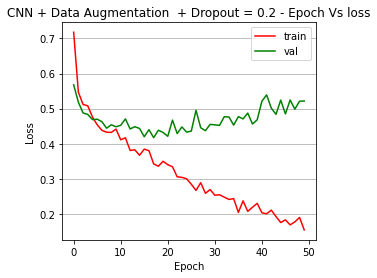

In [ ]:
figure = plt.figure(figsize = (10,4))
ax = plt.subplot(121)

ax.plot(history3.history['loss'], 'r', label = 'train')
ax.plot(history3.history['val_loss'],'g',label = 'val')

plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")


plt.title("CNN + Data Augmentation  + Dropout = 0.2 - Epoch Vs loss")
plt.savefig("Emergency dataset with data augmentation + early stopping")

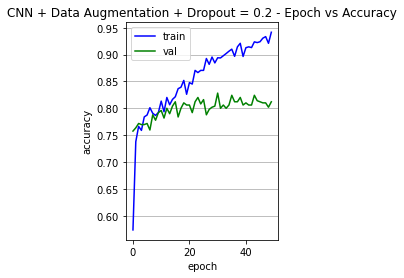

In [ ]:
ax2 = plt.subplot(122)
ax2.plot(history3.history['accuracy'], 'b', label="train")
ax2.plot(history3.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')

plt.title("CNN + Data Augmentation + Dropout = 0.2 - Epoch vs Accuracy")
plt.savefig("Emergency dataset with data augmentation + early stopping")

#### Dropout = 0.4

#### *(a) Building the network*

In [ ]:
model4 = Sequential()
model4.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), padding="same"))
model4.add(tf.keras.layers.MaxPooling2D(2,2))
model4.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dropout(0.4))
model4.add(tf.keras.layers.Dense(10))
model4.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))


model4.compile(optimizer = op,
              loss = loss,
              metrics=['accuracy'])

history4 = model4.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 2s 67ms/step - loss: 0.6802 - accuracy: 0.5695 - val_loss: 0.6460 - val_accuracy: 0.6081
Epoch 2/50
23/23 [==============================] - 1s 60ms/step - loss: 0.6892 - accuracy: 0.5518 - val_loss: 0.6767 - val_accuracy: 0.6081
Epoch 3/50
23/23 [==============================] - 1s 59ms/step - loss: 0.6786 - accuracy: 0.5886 - val_loss: 0.6715 - val_accuracy: 0.6081
Epoch 4/50
23/23 [==============================] - 1s 63ms/step - loss: 0.6846 - accuracy: 0.5668 - val_loss: 0.6699 - val_accuracy: 0.6081
Epoch 5/50
23/23 [==============================] - 1s 56ms/step - loss: 0.6733 - accuracy: 0.5886 - val_loss: 0.6208 - val_accuracy: 0.6364
Epoch 6/50
23/23 [==============================] - 1s 54ms/step - loss: 0.6300 - accuracy: 0.6431 - val_loss: 0.6293 - val_accuracy: 0.6424
Epoch 7/50
23/23 [==============================] - 1s 57ms/step - loss: 0.6003 - accuracy: 0.6894 - val_loss: 0.5699 - val_accuracy: 0.6990
Epoch 8/50
23

#### *(b) Graphing*

Text(0.5, 1.0, 'CNN + Data Augmentation + Dropout = 0.4 - Epoch VS Loss')

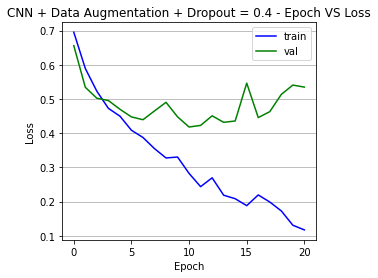

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history2.history['loss'], 'b', label = 'train')
ax.plot(history2.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + Dropout = 0.4 - Epoch VS Loss")

Text(0.5, 1.0, 'CNN + Data Augmentation + Dropout = 0.4 - Epoch VS Accuracy')

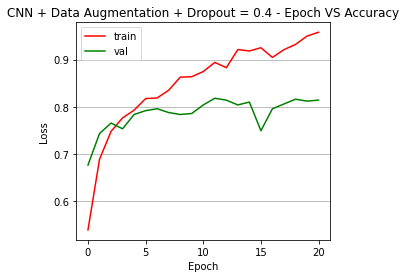

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history2.history['accuracy'], 'r', label = 'train')
ax.plot(history2.history['val_accuracy'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + Dropout = 0.4 - Epoch VS Accuracy")

## (4) Regularization

#### Lasso (L1) regularization

#### *(a) Building the network*

In [ ]:
model5 = Sequential()
model5.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model5.add(tf.keras.layers.MaxPooling2D(2,2))
model5.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(10))
model5.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))


model5.compile(optimizer = op,
              loss = loss,
              metrics=['accuracy'])

history5 = model5.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 2s 63ms/step - loss: 1.0199 - accuracy: 0.5899 - val_loss: 0.8643 - val_accuracy: 0.6586
Epoch 2/50
23/23 [==============================] - 1s 56ms/step - loss: 0.8464 - accuracy: 0.6144 - val_loss: 0.8819 - val_accuracy: 0.5434
Epoch 3/50
23/23 [==============================] - 1s 56ms/step - loss: 0.7471 - accuracy: 0.6839 - val_loss: 0.7092 - val_accuracy: 0.6869
Epoch 4/50
23/23 [==============================] - 1s 63ms/step - loss: 0.6833 - accuracy: 0.6916 - val_loss: 0.6649 - val_accuracy: 0.6788
Epoch 5/50
23/23 [==============================] - 1s 62ms/step - loss: 0.6184 - accuracy: 0.7452 - val_loss: 0.6437 - val_accuracy: 0.7273
Epoch 6/50
23/23 [==============================] - 1s 58ms/step - loss: 0.5980 - accuracy: 0.7275 - val_loss: 0.6662 - val_accuracy: 0.6970
Epoch 7/50
23/23 [==============================] - 1s 54ms/step - loss: 0.6091 - accuracy: 0.7323 - val_loss: 0.5928 - val_accuracy: 0.7455
Epoch 8/50
23

#### *(b) Graphing*

Text(0.5, 1.0, 'CNN + Data Augmentation + L1 regularization - Epoch VS Loss')

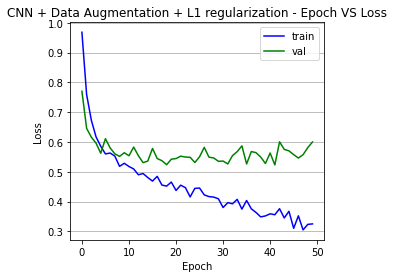

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history5.history['loss'], 'b', label = 'train')
ax.plot(history5.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L1 regularization - Epoch VS Loss")

Text(0.5, 1.0, 'CNN + Data Augmentation + L1 regularization - Epoch VS Accuracy')

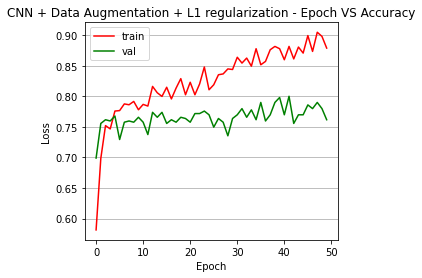

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history5.history['accuracy'], 'r', label = 'train')
ax.plot(history5.history['val_accuracy'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L1 regularization - Epoch VS Accuracy")

#### L2 (Ridge Regression) regularization

#### *(a) Building the network*

In [ ]:
model6 = Sequential()
model6.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(32,32,3), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model6.add(tf.keras.layers.MaxPooling2D(2,2))
model6.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model6.add(tf.keras.layers.Flatten())
model6.add(tf.keras.layers.Dense(10))
model6.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))


model6.compile(optimizer = op,
              loss = loss,
              metrics=['accuracy'])

history6 = model6.fit(traingen, steps_per_epoch = num_train_samples/50,
                    epochs = 50, validation_data = valgen,
                    validation_steps = num_val_samples/50)

Epoch 1/50
23/23 [==============================] - 2s 68ms/step - loss: 0.7531 - accuracy: 0.5817 - val_loss: 0.6761 - val_accuracy: 0.6303
Epoch 2/50
23/23 [==============================] - 1s 63ms/step - loss: 0.7043 - accuracy: 0.6253 - val_loss: 0.6982 - val_accuracy: 0.6222
Epoch 3/50
23/23 [==============================] - 1s 55ms/step - loss: 0.6781 - accuracy: 0.6362 - val_loss: 0.6740 - val_accuracy: 0.6242
Epoch 4/50
23/23 [==============================] - 1s 58ms/step - loss: 0.6377 - accuracy: 0.6889 - val_loss: 0.6885 - val_accuracy: 0.6424
Epoch 5/50
23/23 [==============================] - 1s 56ms/step - loss: 0.6107 - accuracy: 0.7133 - val_loss: 0.6062 - val_accuracy: 0.7111
Epoch 6/50
23/23 [==============================] - 1s 56ms/step - loss: 0.6086 - accuracy: 0.7207 - val_loss: 0.5836 - val_accuracy: 0.6990
Epoch 7/50
23/23 [==============================] - 1s 53ms/step - loss: 0.5406 - accuracy: 0.7514 - val_loss: 0.5510 - val_accuracy: 0.7556
Epoch 8/50
23

#### *(b) Graphing*

Text(0.5, 1.0, 'CNN + Data Augmentation + L2 regularization - Epoch VS Loss')

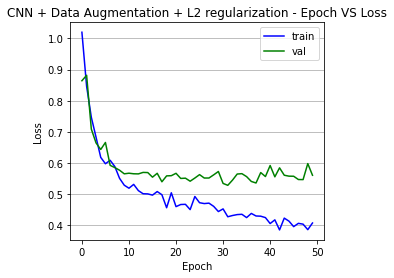

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history5.history['loss'], 'b', label = 'train')
ax.plot(history5.history['val_loss'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L2 regularization - Epoch VS Loss")

Text(0.5, 1.0, 'CNN + Data Augmentation + L2 regularization - Epoch VS Accuracy')

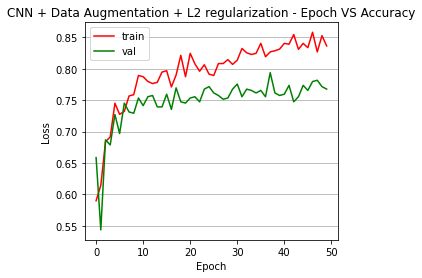

In [ ]:
figure = plt.figure(figsize = (10,4))

ax = plt.subplot(121)
ax.plot(history5.history['accuracy'], 'r', label = 'train')
ax.plot(history5.history['val_accuracy'],'g',label = 'val')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN + Data Augmentation + L2 regularization - Epoch VS Accuracy")